# 僵尸企业识别项目
## 数据预处理

首先加载必须的库：
- 用于读取和处理数据表：pandas, numpy, sklearn.preprocessing(标准化)
- 用于可视化：matplotlib, seaborn

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn import preprocessing


### 定义辅助函数
1. `mypairplot`: 两两之间展示特征的联合分布特征
2. `addTimeSeriesFeatures`: 为时序型特征（年报、融资）构建均值、一二阶差分特征
3. `fillYear`: 根据均包含2015-2017三年信息这个共性，对公司的缺失年份值进行补全
4. `addSlopeFeatures`: 为年报特征新增对比值型特征

In [24]:
def mypairplot(df, flag, dots):
  df = df.set_index('ID')
  df.iloc[:, :] = preprocessing.scale(df.to_numpy())
  df = pd.merge(df, flag, left_index=True, right_on='ID').drop('ID', axis=1).sample(dots)
  try:
    df = df.drop('year', axis=1)
  except:
    pass
  g = sns.PairGrid(df, hue='flag')
  g.map_lower(sns.kdeplot, shade=True, shade_lowest=False)
  g.map_diag(plt.hist)
  g.map_upper(plt.scatter)
  g.add_legend()


def addTimeSeriesFeatures(df: pd.DataFrame):

  baseline = df.drop('year', axis=1).groupby('ID').mean()
  baseline.columns = [c + '_mean' for c in baseline.columns]

  def getYearData(yr): return df[df.year == yr].set_index('ID').drop('year', axis=1)

  # get year diff
  d2015, d2016, d2017 = (getYearData(y) for y in (2015, 2016, 2017))
  diffmean = d2017 - d2015
  diffmean.columns = [c + '_diff_mean' for c in diffmean.columns]
  diffdiff = d2017 + d2015 - 2 * d2016
  diffdiff.columns = [c + '_diff_diff' for c in diffdiff.columns]

  return pd.concat([baseline, diffmean, diffdiff], axis=1)


def fillYear(df):
  yearPad = df.year.fillna('pad')
  yearGrp = df.groupby(yearPad)

  commonID = np.intersect1d(yearGrp.get_group(2015).ID,
                            yearGrp.get_group(2016).ID)
  commonID = np.intersect1d(yearGrp.get_group(2017).ID, commonID)

  wrongID = np.setdiff1d(df.ID, commonID)
  for i in wrongID:
    years = df.year[df.ID==i]
    missingYear = set([2015., 2016., 2017.]) - set(years)
    missingYearIdx = years[years.isna()].index
    for idx in missingYearIdx:
      df.at[idx, 'year'] = missingYear.pop()
  
  df.loc[df.year.isna(), 'year'] = yearPad[df.year.isna()]
  return df


# add slope features to year report
def addSlopeFeatures(reportdf):
  ratePairs = {
    '资产总额': ['负债总额', '营业总收入'],
    '营业总收入': ['主营业务收入', '利润总额', '净利润', '纳税总额']
  }
  for x in ratePairs.keys():
    for y in ratePairs[x]:
      bottomIdx = reportdf[y].idxmin()
      xmin, ymin = reportdf[x][bottomIdx], reportdf[y][bottomIdx]
      slope = (reportdf[y] - ymin) / (reportdf[x] - xmin)
      yna = reportdf[y].isna()
      reportdf.loc[yna, y] = slope.median() * (reportdf.loc[yna, x] - reportdf[x].min()) + reportdf[y].min()
      angle = np.arctan(slope.fillna(slope.median()))
      reportdf[y+'/'+x] = angle
  
  return reportdf


### 读取源数据
设置数据读取路径

In [25]:
  # sns.set(font='Microsoft Yahei')

  # set data files
  datasetConfig = {
    'train': {
      'base': 'base_train_sum.csv',
      'finance': 'money_report_train_sum.csv',
      'patent': 'patent_train_sum.csv',
      'report': 'year_report_train_sum.csv'
    },
    'validate': {
      'base': 'base_verify1.csv',
      'finance': 'money_information_verify1.csv',
      'patent': 'patent_information_verify1.csv',
      'report': 'year_report_verify1.csv'
    },
    'validate2': {
      'base': 'base_verify2_sum.csv',
      'finance': 'money_report_verify2_sum.csv',
      'patent': 'knowledge_verify2_sum.csv',
      'report': 'year_report_verify2_sum.csv'
    },
    'test': {
      'base': 'base_test_sum.csv',
      'finance': 'money_report_test_sum.csv',
      'patent': 'knowledge_test_sum.csv',
      'report': 'year_report_test_sum.csv'
    }
  }
  MODE = 'validate'


读取数据表

In [26]:
  basedf, financedf, patentdf, reportdf = (pd.read_csv(os.path.join(
    'dataset', datasetConfig[MODE][sub])) for sub in datasetConfig['train'].keys())
  if MODE != 'test':
    flagdf = basedf[['ID', 'flag']]
    basedf = basedf.drop('flag', axis=1)
  basedf0, financedf0, patentdf0, reportdf0 = basedf.copy(), financedf.copy(), patentdf.copy(), reportdf.copy()


### 数据可视化和预处理

#### 注册信息(basedf) 和 知识产权信息(patentdf)

In [5]:
basedf.dtypes

ID           int64
注册时间       float64
注册资本       float64
行业          object
区域          object
企业类型        object
控制人类型       object
控制人持股比例    float64
dtype: object

In [6]:
basedf.describe()

,ID,注册时间,注册资本,控制人持股比例
count,1.505000e+04,14879.000000,14909.000000,14911.000000
mean,3.527931e+06,2006.898515,5003.630693,0.755561
std,2.622221e+06,4.311774,2873.938399,0.144000
min,2.800000e+01,2000.000000,100.000000,0.510000
25%,8.036028e+05,2003.000000,2500.000000,0.630000
50%,5.970482e+06,2007.000000,4980.000000,0.760000
75%,5.974260e+06,2011.000000,7510.000000,0.880000
max,5.978033e+06,2014.000000,10000.000000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3c9f23e8d0>,
      dtype=object)

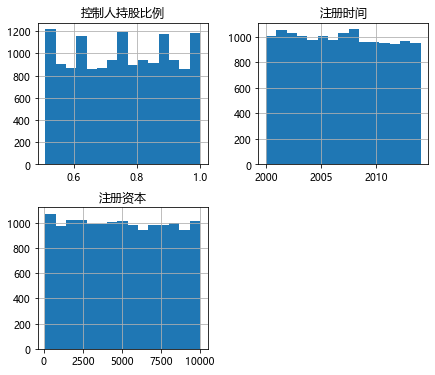

In [7]:
basedf.iloc[:, 1:].hist(figsize=(7,6), bins=15)

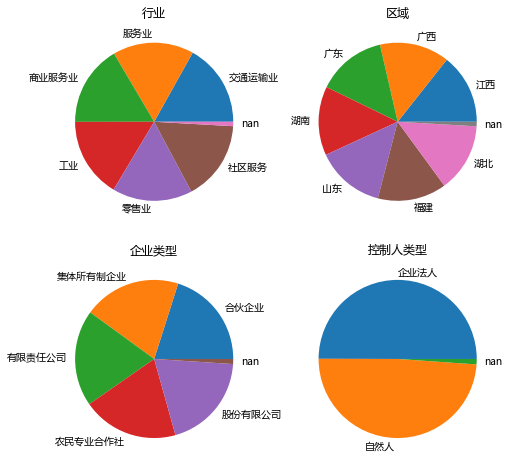

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))
for feat, ax in zip(basedf[['行业', '区域', '企业类型', '控制人类型']], axes.flatten()):
    count = basedf[feat].value_counts(dropna=False)
    ax.pie(count, labels=count.index)
    ax.set(title=feat)

对数据表进行均值插补，并且进行哑变量变换

In [28]:
  # fill NA in basedf
  basedfNumeric = basedf[['ID', '注册时间', '注册资本', '控制人持股比例']]
  basedfNumeric = basedfNumeric.fillna(basedfNumeric.mean())
  # basedf[['行业', '区域', '企业类型', '控制人类型']] = basedf[['行业', '区域', '企业类型', '控制人类型']].fillna('NA')
  basedf = pd.concat([basedfNumeric,
                      pd.get_dummies(basedf.行业, prefix='行业'),
                      pd.get_dummies(basedf.区域, prefix='区域'),
                      pd.get_dummies(basedf.企业类型, prefix='企业类型'),
                      pd.get_dummies(basedf.控制人类型, prefix='控制人类型'), ], axis=1)


类似地，观察patentdf的数值分布信息：

In [10]:
patentdf.describe()

,ID,专利,商标,著作权
count,1.505000e+04,14899.000000,14895.000000,14911.000000
mean,3.527931e+06,0.348480,0.356764,0.367447
std,2.622221e+06,0.476505,0.479060,0.482126
min,2.800000e+01,0.000000,0.000000,0.000000
25%,8.036028e+05,0.000000,0.000000,0.000000
50%,5.970482e+06,0.000000,0.000000,0.000000
75%,5.974260e+06,1.000000,1.000000,1.000000
max,5.978033e+06,1.000000,1.000000,1.000000


In [29]:
  # fill NA in patentdf
  # patentdf = patentdf.fillna('NA')
  patentdf.iloc[:, 1:] = patentdf.iloc[:, 1:].astype('float')
  patentdf = pd.concat([patentdf.ID,
                        pd.get_dummies(patentdf.专利, prefix='专利'),
                        pd.get_dummies(patentdf.商标, prefix='商标'),
                        pd.get_dummies(patentdf.著作权, prefix='著作权')], axis=1)



查看数据表的变量相关性信息

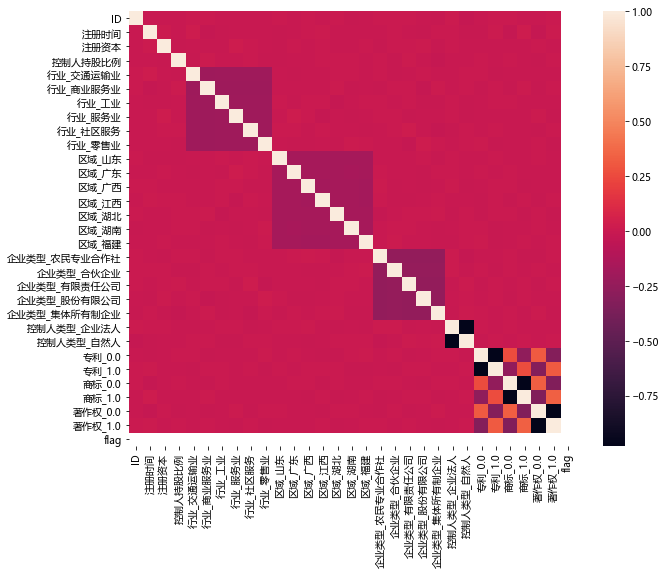

In [12]:
jointdf = pd.merge(basedf, patentdf, on='ID')
jointdf = pd.merge(jointdf, flagdf, on='ID')
fig = plt.figure(figsize=(10,8))
sns.heatmap(jointdf.corr())

#### 融资信息(financedf) 和 财报信息(reportdf)
首先同样观察数据分布：

In [13]:
reportdf.dtypes

ID           int64
year       float64
从业人数       float64
资产总额       float64
负债总额       float64
营业总收入      float64
主营业务收入     float64
利润总额       float64
净利润        float64
纳税总额       float64
所有者权益合计    float64
dtype: object

In [14]:
financedf.dtypes

ID               int64
year           float64
债权融资额度         float64
债权融资成本         float64
股权融资额度         float64
股权融资成本         float64
内部融资和贸易融资额度    float64
内部融资和贸易融资成本    float64
项目融资和政策融资额度    float64
项目融资和政策融资成本    float64
dtype: object

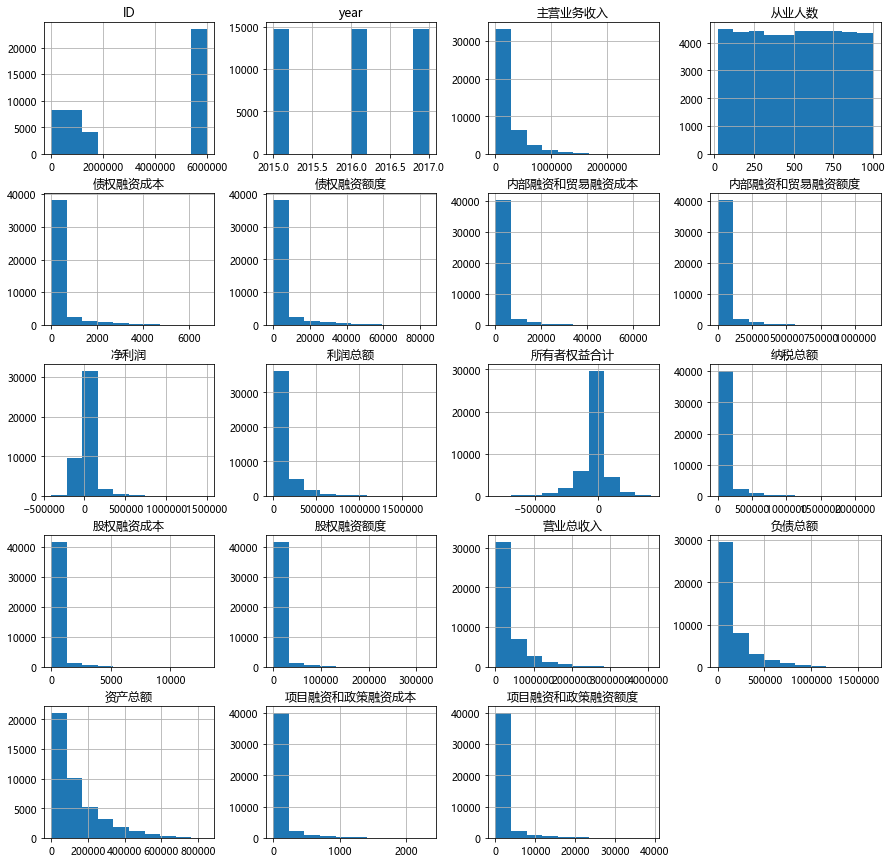

In [15]:
jointdf = pd.merge(reportdf, financedf, on=['ID', 'year'])
g = jointdf.hist(figsize=(15,15))

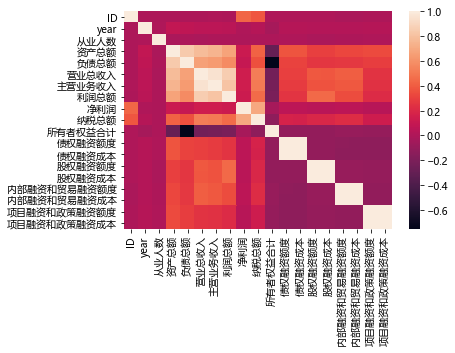

In [16]:
sns.heatmap(jointdf.corr())

利用变量间的共线性，互相进行融资信息的插补

In [30]:
  # fill NA in financedf
  # filling with quota-rate relationship 存在先验假设
  financeCategories = {'债权融资': 0.08, '股权融资': 0.04,
                      '内部融资和贸易融资': 0.06, '项目融资和政策融资': 0.06}
  for c, rate in financeCategories.items():
    quota = c+'额度'
    cost = c+'成本'
    quotaNull = financedf[quota].isnull() & financedf[cost].notnull()
    financedf.loc[quotaNull, quota] = financedf.loc[quotaNull, cost] / rate
    # drop duplicates
    financedf = financedf.drop(cost, axis=1)

  # other numeric values: use median = 0
  # log-like transformation
  financedf.iloc[:, 2:] = financedf.iloc[:, 2:].fillna(0).applymap(np.log1p)
  # fill NA in year by padding
  financedf = fillYear(financedf)
  financedf = addTimeSeriesFeatures(financedf)


对年报中的变量进行更细致的相关性分析：

/home/miosolo/bin/miniconda3/lib/python3.7/site-packages/scipy/stats/kde.py:581: RuntimeWarning: invalid value encountered in sqrt
  self._norm_factor = sqrt(linalg.det(2*pi*self.covariance))


LinAlgError: 1-th leading minor of the array is not positive definite

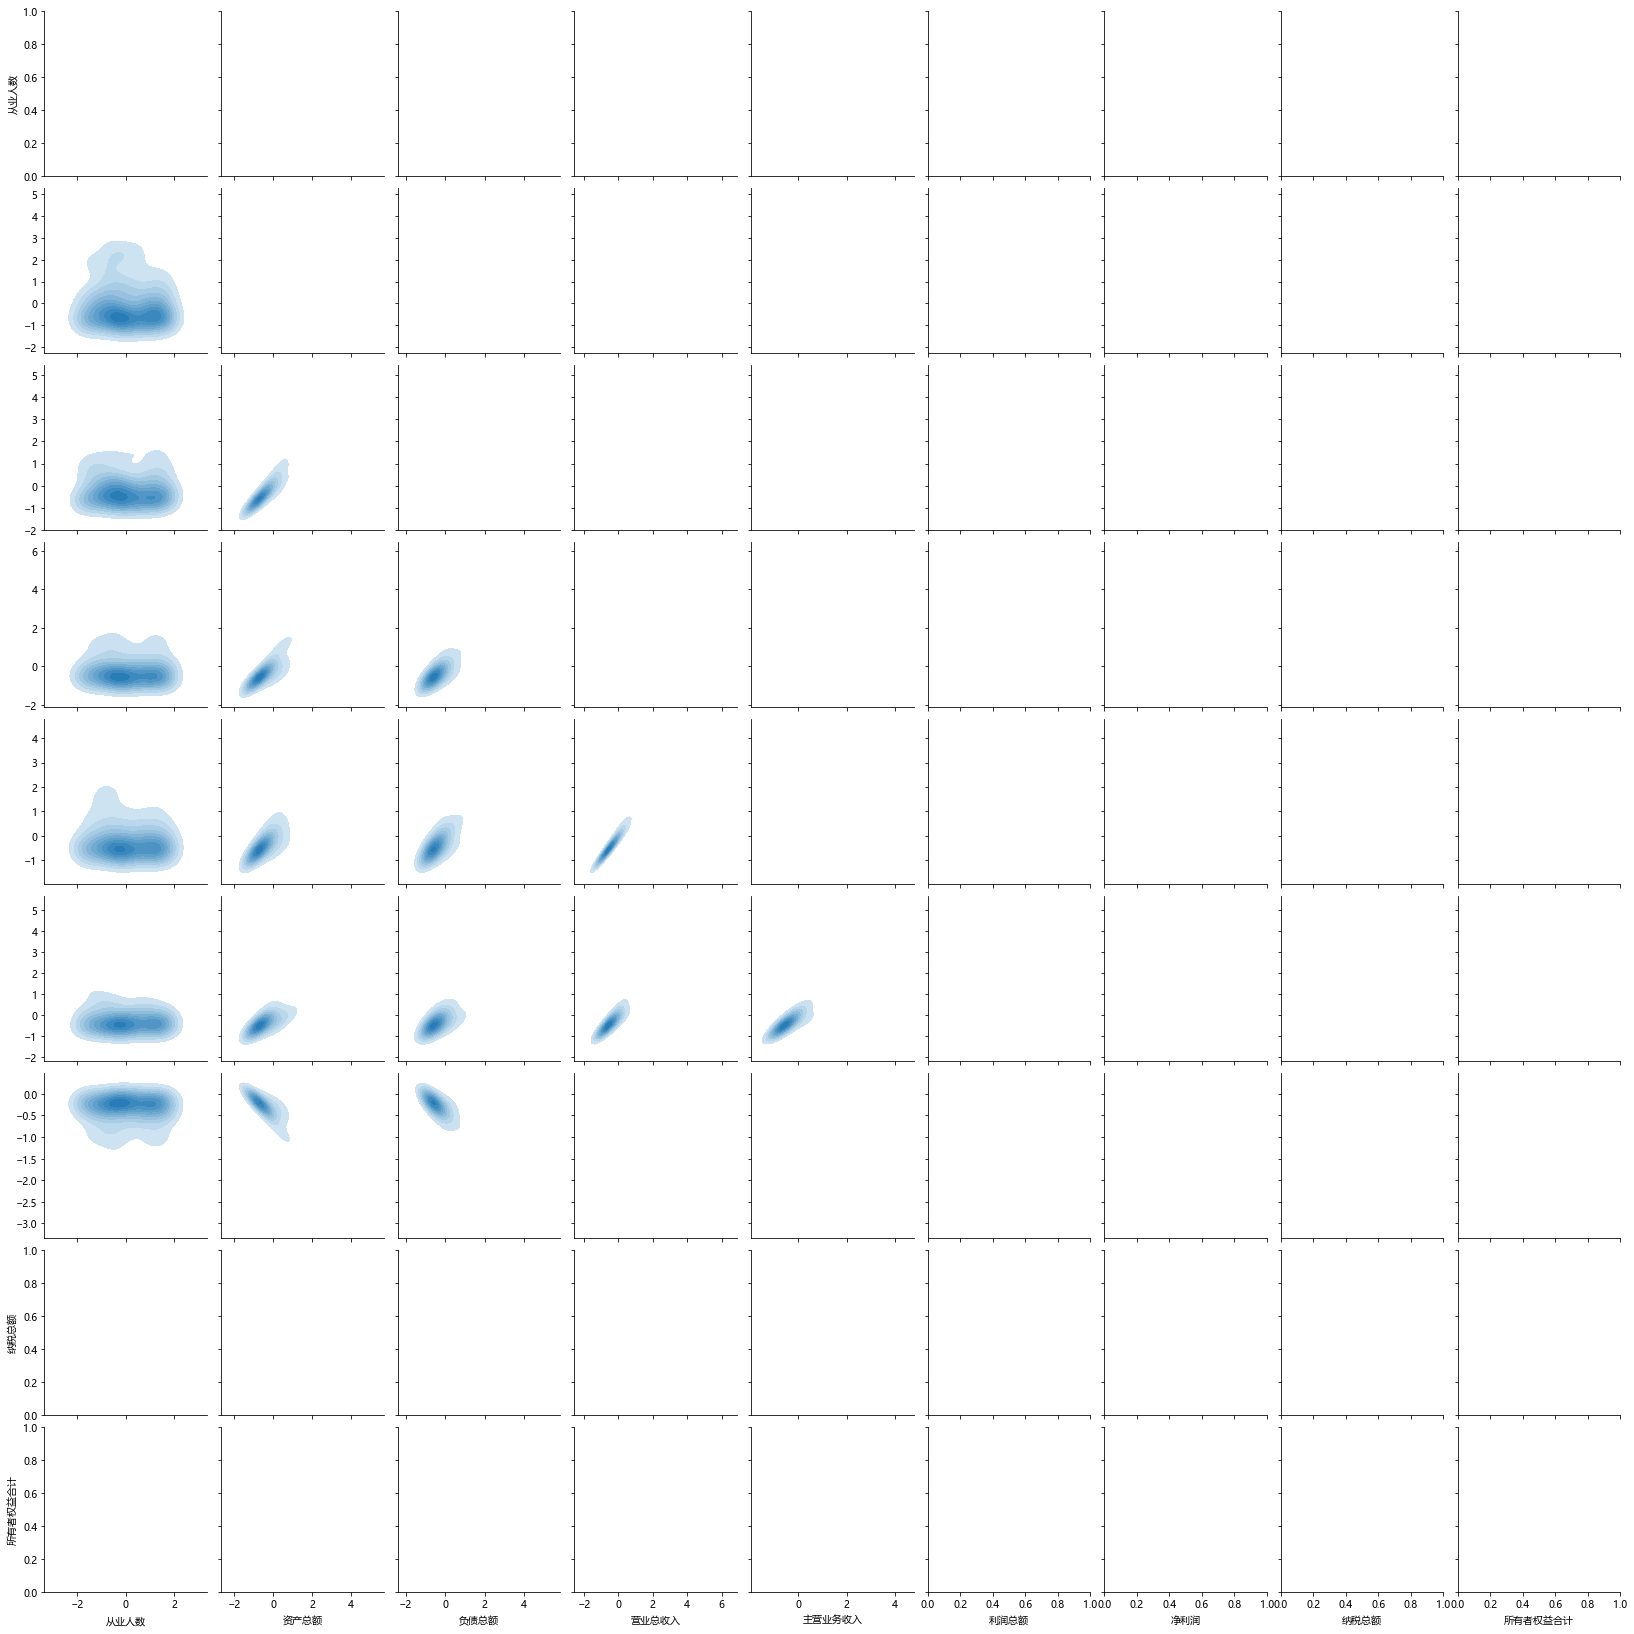

In [18]:
mypairplot(reportdf, flagdf, dots=500)

添加斜率特征和时序特征，并且利用斜率特征进行缺失值插补

In [31]:
  # fill NA in reportdf
  # discard surplus, duplicate
  reportdf = reportdf.drop('所有者权益合计', axis=1)

  # filling personnel by mean, since irrelavance
  reportdf.从业人数 = reportdf.从业人数.fillna(reportdf.从业人数.mean())
  reportdf.资产总额 = reportdf.资产总额.fillna(reportdf.资产总额.median())

  # replace highly-dependent vars with rate
  reportdf = addSlopeFeatures(reportdf)
  # reportdf = reportdf.drop(np.sum(list(ratePairs.values())), axis=1)
  # padding year
  reportdf = fillYear(reportdf)
  reportdf = addTimeSeriesFeatures(reportdf)


In [32]:
  # store results
  basedf.to_hdf('dataset/preprocessed-data.h5', key='base_'+MODE)
  patentdf.to_hdf('dataset/preprocessed-data.h5', key='patent_'+MODE)
  financedf.to_hdf('dataset/preprocessed-data.h5', key='finance_'+MODE)
  reportdf.to_hdf('dataset/preprocessed-data.h5', key='report_'+MODE)
  if MODE != 'test':
    flagdf.to_hdf('dataset/preprocessed-data.h5', key='flag_'+MODE)


In [33]:
  aiodf = basedf
  for df in (patentdf, financedf, reportdf):
    aiodf = pd.merge(aiodf, df, on='ID')
  aiodf.to_hdf('dataset/preprocessed-data.h5', key='all_'+MODE)


In [34]:
aiodf.shape

(30883, 84)